# Data_Cleaning, Data_Engineering, Data_Visualizations

## Carbon Price Group

### 1. Setup & Load Skeleton

**Explanation:** We reload the exact same stock skeleton used for the other macro variables to ensure perfect date alignment.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates to create the Master Timeline
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

print(f"Skeleton Dates: {len(unique_dates)}")

Skeleton Dates: 3443


### 2. Load, Clean, and Merge Carbon Data

**Explanation:** We load the raw carbon file, isolate the date and price, and force the price column to numeric (this turns the empty cell from 1/8/2010 into a NaN). We then Left Join it to the skeleton and apply ffill to carry Thursday's price over to Friday if Friday is missing.

In [15]:
# 1. Load Raw Carbon Data (Update filename if different)
carbon_path = os.path.join(raw_dir, "carbon_price_eua_daily_investing_clean.csv") 
df_carbon_raw = pd.read_csv(carbon_path)

# Format dates
df_carbon_raw['date'] = pd.to_datetime(df_carbon_raw['date'])

# 2. Clean and isolate necessary columns
# We drop 'source' and rename 'price_eur' for consistency
df_carbon_clean = df_carbon_raw[['date', 'price_eur']].rename(columns={'price_eur': 'Carbon_Price'})

# Force to numeric (coerces empty strings/blanks to NaN)
df_carbon_clean['Carbon_Price'] = pd.to_numeric(df_carbon_clean['Carbon_Price'], errors='coerce')

# 3. Merge with Skeleton (Left Join)
df_carbon_merged = pd.merge(unique_dates, df_carbon_clean, on='date', how='left')

# 4. Impute Missing Values (Forward Fill for empty cells/holidays)
df_carbon_merged['Carbon_Price'] = df_carbon_merged['Carbon_Price'].ffill()
df_carbon_merged['Carbon_Price'] = df_carbon_merged['Carbon_Price'].bfill()

print(f"Merged Carbon Shape: {df_carbon_merged.shape}")
print(f"Missing Values after Imputation: {df_carbon_merged['Carbon_Price'].isna().sum()}")
df_carbon_merged.head()

Merged Carbon Shape: (3443, 2)
Missing Values after Imputation: 0


,date,Carbon_Price
0,2010-04-27,15.25
1,2010-04-28,14.98
2,2010-04-29,15.35
3,2010-04-30,15.94
4,2010-05-03,16.52


### 3. Feature Engineering (Carbon Specific)

**Explanation:** We calculate the standard suite of financial features: RSI, Log Returns, Moving Averages, and Volatility.

In [17]:
# Helper Function for RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Log Returns
df_carbon_merged['Carbon_Log_Return'] = np.log(df_carbon_merged['Carbon_Price'] / df_carbon_merged['Carbon_Price'].shift(1))

# 2. RSI (14-Day)
df_carbon_merged['Carbon_RSI'] = calculate_rsi(df_carbon_merged['Carbon_Price'])

# 3. Moving Averages
df_carbon_merged['Carbon_MA7'] = df_carbon_merged['Carbon_Price'].rolling(window=7).mean()
df_carbon_merged['Carbon_MA50'] = df_carbon_merged['Carbon_Price'].rolling(window=50).mean()

# 4. Volatility (7-Day Rolling Std Dev)
df_carbon_merged['Carbon_Vol7'] = df_carbon_merged['Carbon_Log_Return'].rolling(window=7).std()

print("Carbon Feature Engineering Complete.")
df_carbon_merged.tail()

Carbon Feature Engineering Complete.


,date,Carbon_Price,Carbon_Log_Return,Carbon_RSI,Carbon_MA7,Carbon_MA50,Carbon_Vol7
3438,2023-12-21,78.14,0.036225,62.740708,71.475714,75.8488,0.030744
3439,2023-12-22,79.14,0.012716,70.436415,72.941429,75.7226,0.030586
3440,2023-12-26,79.14,0.000000,75.846387,74.714286,75.5922,0.023115
3441,2023-12-27,80.04,0.011308,76.841085,76.495714,75.5248,0.023222
3442,2023-12-28,80.24,0.002496,75.895108,77.712857,75.4766,0.018196


### 4. Save Semi-Clean Dataset

**Explanation:** Saving this as the 9th engineered file in your directory.

In [23]:
output_path = os.path.join(semi_clean_dir, "carbon_engineered_9.csv")
df_carbon_merged.to_csv(output_path, index=False)
print(f"Saved processed Carbon data to: {output_path}")

Saved processed Carbon data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\carbon_engineered_9.csv


### 5. Overlay Visualization (Stock vs. Carbon Price)

**Explanation:** Creates the 7 graphs. The Stock Price is on the left axis (Navy), and the Carbon Price is on the right axis (Dim Grey to represent emissions).

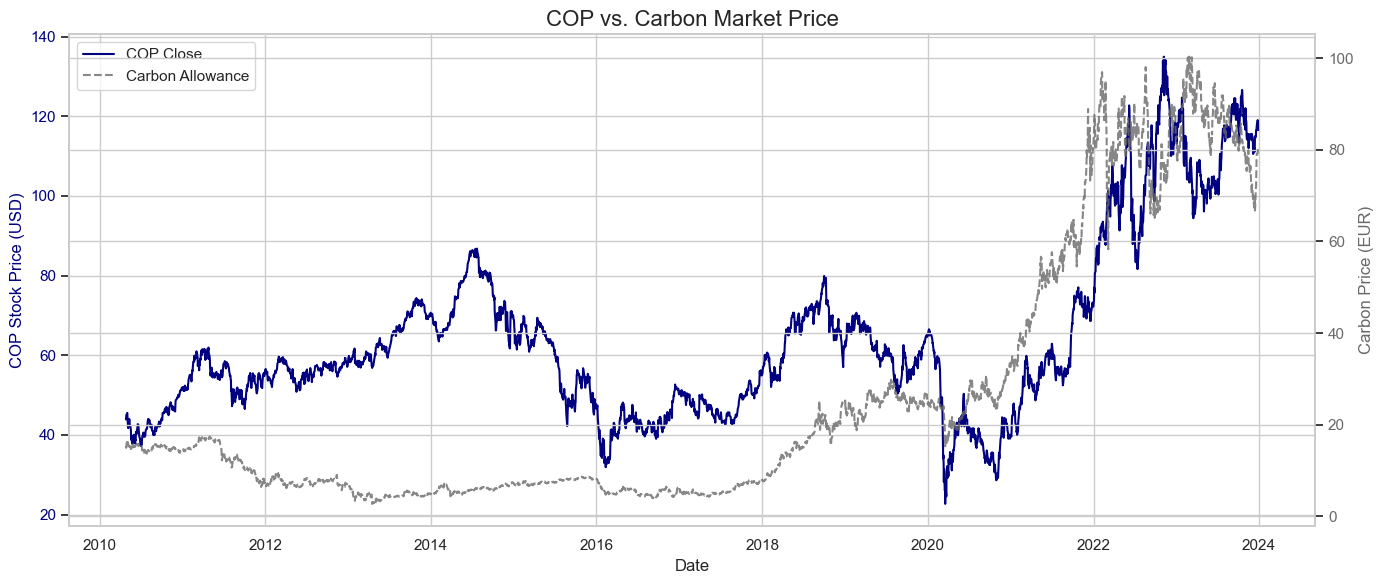

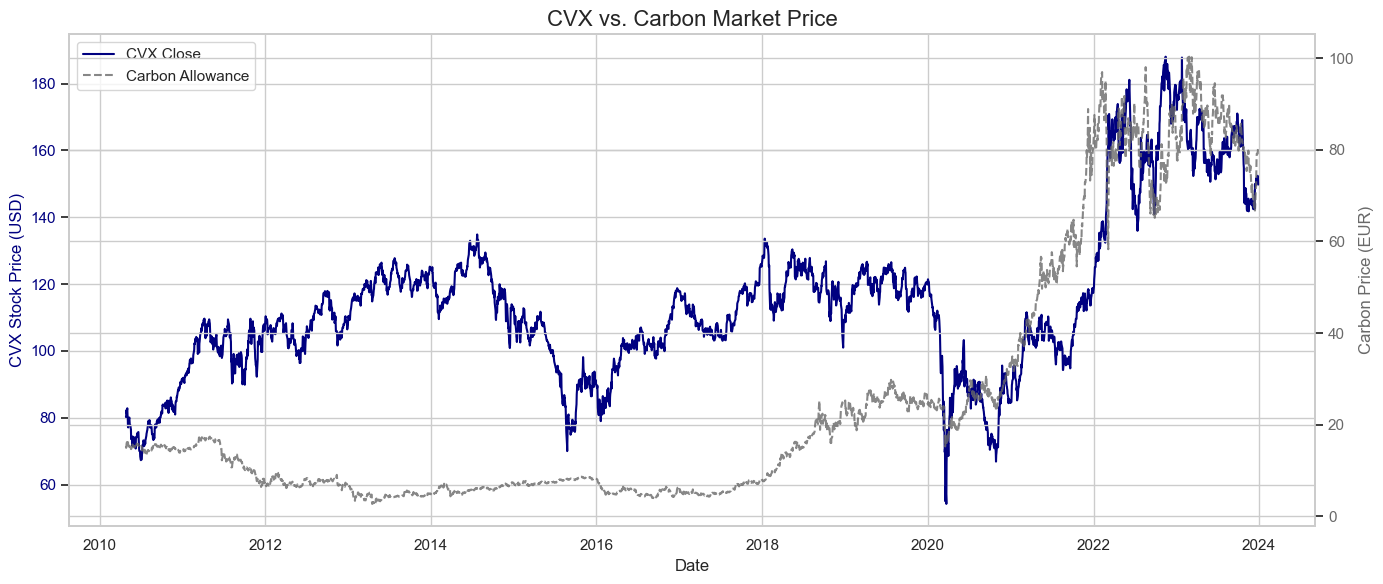

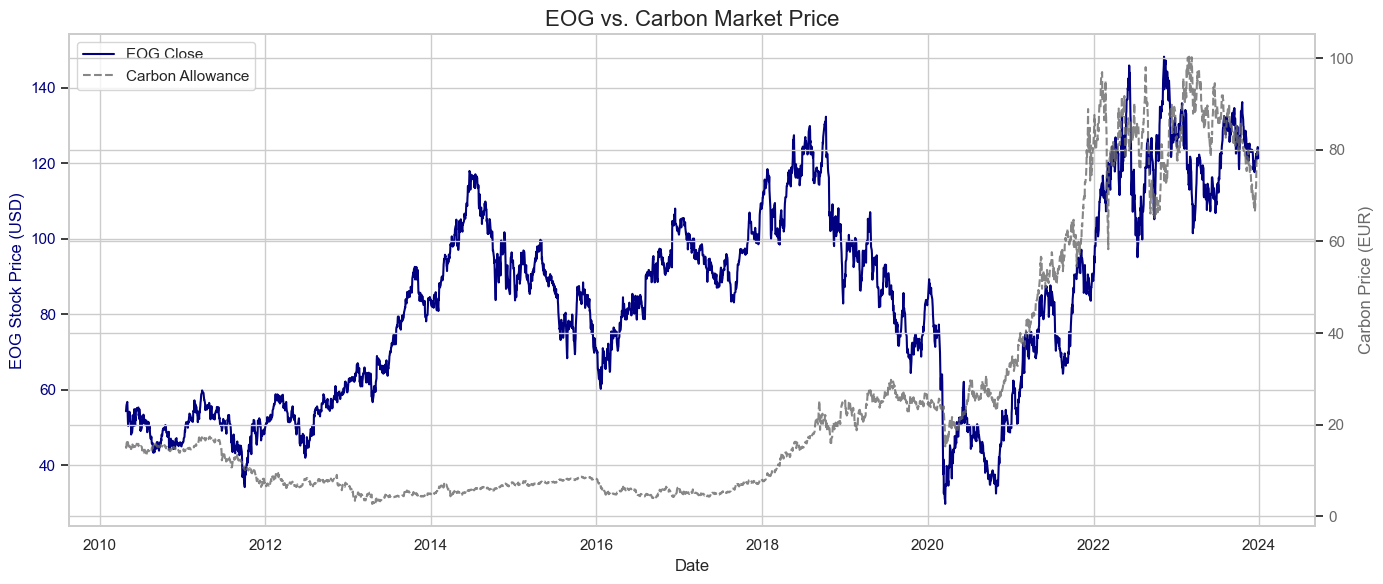

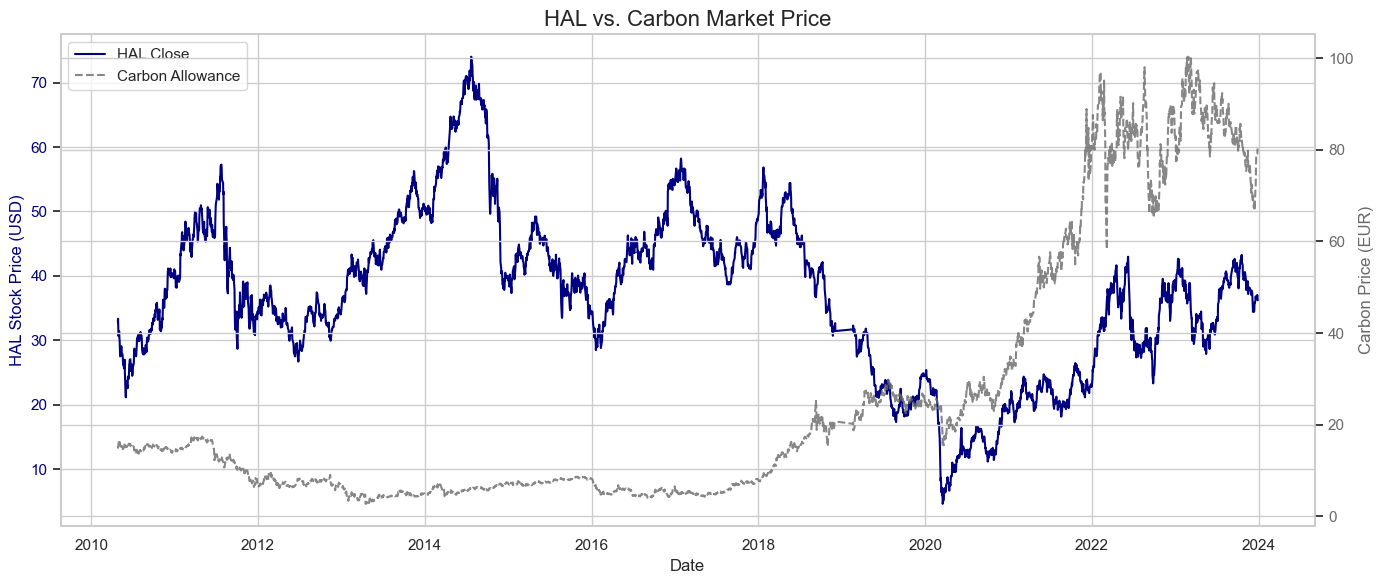

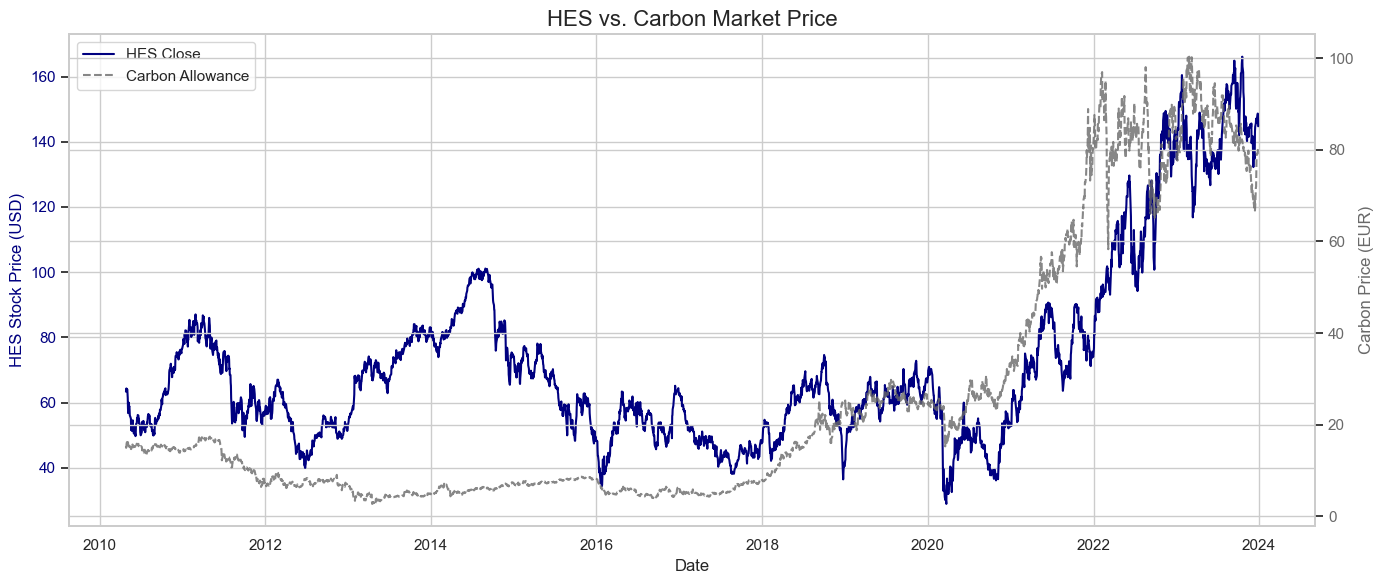

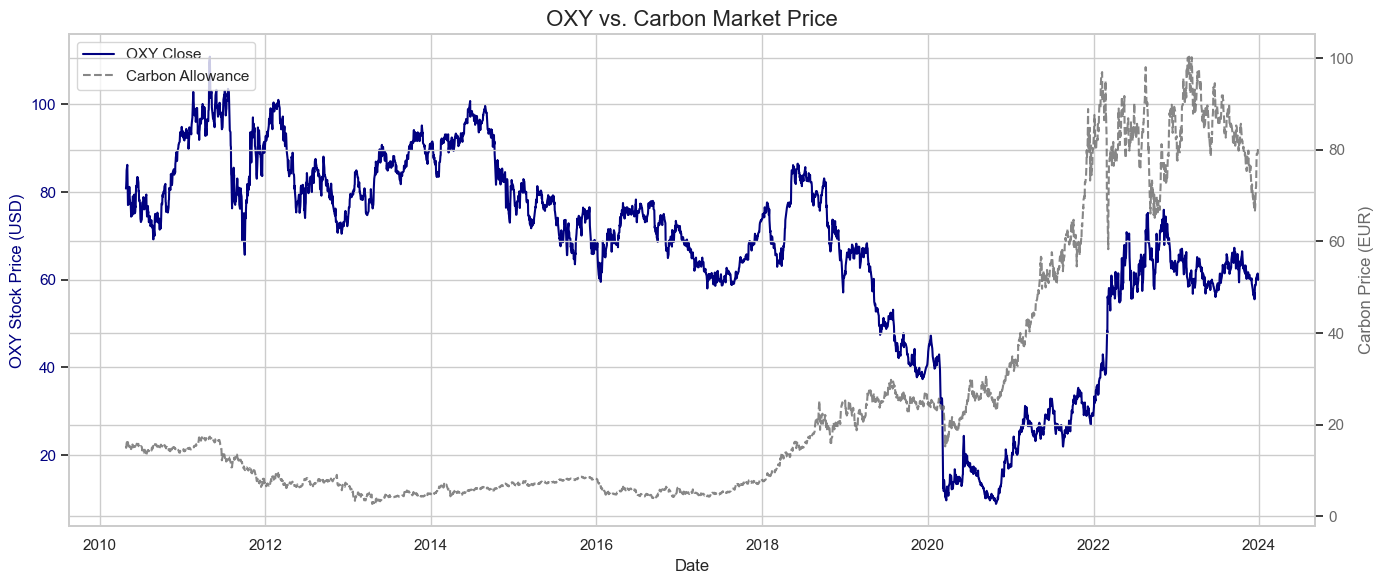

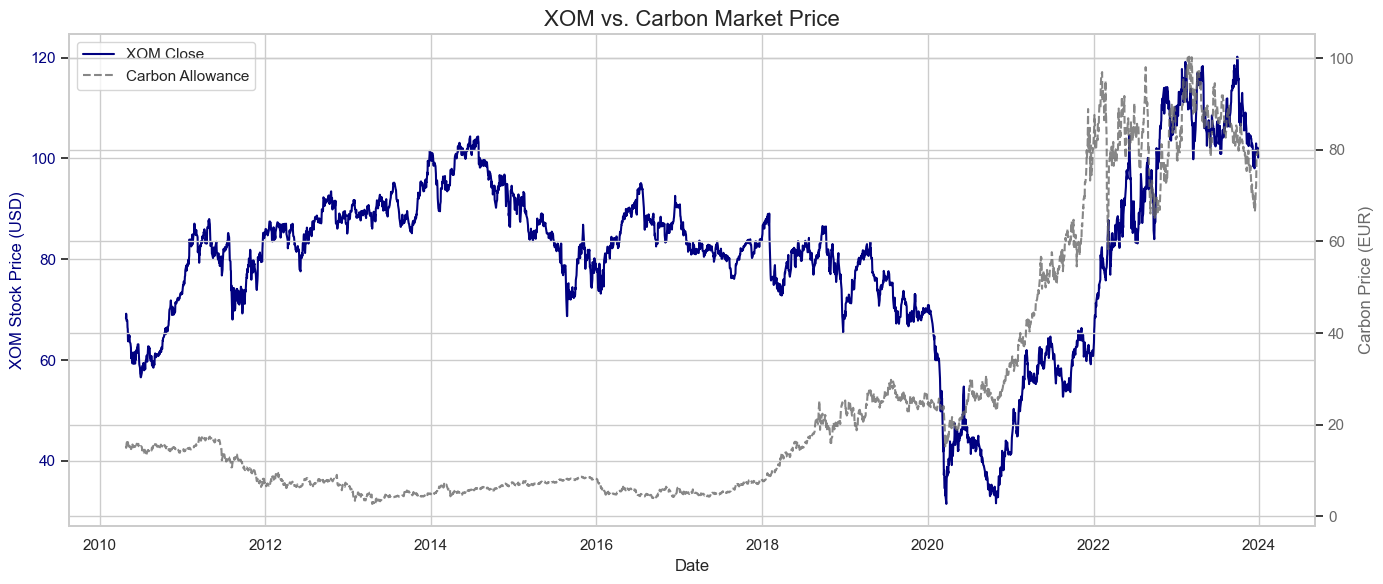

In [26]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_carbon_merged, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="whitegrid")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. Carbon Price (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'dimgrey'
    ax2.set_ylabel('Carbon Price (EUR)', color=color2, fontsize=12)
    ax2.plot(subset['date'], subset['Carbon_Price'], color=color2, label='Carbon Allowance', linestyle='--', alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. Carbon Market Price", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()